
# 📘 S1.2 時間序列進階分析

本課程是時間序列分析特別專題的第二部分，專注於進階時間序列分析技術。在上一課程中，我們學習了時間序列的基礎知識，包括時間索引創建、基本操作和日期範圍。本課程將深入探討重採樣、移動窗口計算、季節性分解和時間序列預測等進階技術，這些方法在分析動態時間模式和預測未來趨勢方面非常有用。


## 🎯 教學目標

- 🔄 掌握時間序列重採樣與頻率轉換技術
- 📈 學習移動窗口計算和滾動統計分析
- 🌊 理解時間序列分解與季節性模式識別方法
- 🔮 探索時間序列預測的基本技術

In [42]:
# 環境設置
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings

# 忽略警告信息
warnings.filterwarnings('ignore')

# 設置隨機種子確保結果可重現
np.random.seed(42)

In [43]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# # 設置可視化風格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 微軟正黑體或思源黑體路徑 (請依你電腦為準)
font_path = "C:/Windows/Fonts/msjh.ttc"  # 或 simsun.ttc, NotoSansCJK, 等

# 建立 FontProperties
font_prop = fm.FontProperties(fname=font_path)

# 設定 matplotlib 全域字型（包括標題、座標軸、legend）
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 避免負號亂碼

# 設置顯示選項
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 100)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)


## 📊 1. 重採樣與頻率轉換

重採樣是時間序列分析中的重要操作，可以將時間序列從一個頻率轉換為另一個頻率。主要包括：

- **下採樣 (Downsampling)**: 將高頻數據轉換為低頻數據 (如將日數據轉換為月數據)
- **上採樣 (Upsampling)**: 將低頻數據轉換為高頻數據 (如將月數據轉換為日數據)

In [44]:
# 1.1 創建示例時間序列數據
# 創建一年的每日時間序列數據 (模擬每日銷售額)
dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
daily_sales = pd.Series(
    np.random.normal(loc=1000, scale=200, size=len(dates)) + 
    np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 200,  # 添加年度季節性模式
    index=dates, 
    name='銷售額'
)

# 為週末增加銷售額
daily_sales[daily_sales.index.dayofweek >= 5] *= 1.5

print("每日銷售數據 (前10行):")
print(daily_sales.head(10))
print(f"總天數: {len(daily_sales)}")

每日銷售數據 (前10行):
2022-01-01   1649.01
2022-01-02   1463.68
2022-01-03   1136.42
2022-01-04   1314.93
2022-01-05    966.93
2022-01-06    970.37
2022-01-07   1336.46
2022-01-08   1766.29
2022-01-09   1400.34
2022-01-10   1139.37
Freq: D, Name: 銷售額, dtype: float64
總天數: 365


In [45]:
# 1.2 下採樣 (Downsampling) - 將日數據轉換為更低頻率
# 1.2.1 日→週
weekly_sales = daily_sales.resample('W').mean()  # 每週平均銷售額
print("\n每週平均銷售額 (前5行):")
print(weekly_sales.head())

# 1.2.2 日→月
monthly_sales = daily_sales.resample('M').mean()  # 每月平均銷售額
print("\n每月平均銷售額:")
print(monthly_sales)

# 1.2.3 使用不同的聚合方法
monthly_stats = pd.DataFrame({
    '平均值': daily_sales.resample('M').mean(),
    '總和': daily_sales.resample('M').sum(),
    '最大值': daily_sales.resample('M').max(),
    '最小值': daily_sales.resample('M').min(),
    '標準差': daily_sales.resample('M').std(),
    '天數': daily_sales.resample('M').count()
})

print("\n月度銷售統計:")
print(monthly_stats)


每週平均銷售額 (前5行):
2022-01-02   1556.35
2022-01-09   1270.25
2022-01-16   1034.09
2022-01-23   1166.25
2022-01-30   1129.34
Freq: W-SUN, Name: 銷售額, dtype: float64

每月平均銷售額:
2022-01-31   1170.66
2022-02-28   1257.35
2022-03-31   1351.26
2022-04-30   1386.22
2022-05-31   1291.93
2022-06-30   1261.04
2022-07-31   1121.73
2022-08-31    970.78
2022-09-30    907.80
2022-10-31    953.36
2022-11-30   1028.89
2022-12-31   1074.15
Freq: ME, Name: 銷售額, dtype: float64

月度銷售統計:
               平均值       總和     最大值    最小值    標準差  天數
2022-01-31 1170.66 36290.57 1766.29 661.73 292.78  31
2022-02-28 1257.35 35205.75 1824.72 727.01 280.95  28
2022-03-31 1351.26 41888.91 2243.37 667.30 340.13  31
2022-04-30 1386.22 41586.71 2518.19 805.92 439.72  30
2022-05-31 1291.93 40049.96 2088.69 806.91 350.91  31
2022-06-30 1261.04 37831.26 1951.26 843.61 307.71  30
2022-07-31 1121.73 34773.74 1712.46 714.90 286.63  31
2022-08-31  970.78 30094.31 1626.27 435.73 293.57  31
2022-09-30  907.80 27234.10 1857.43 155.82 371.

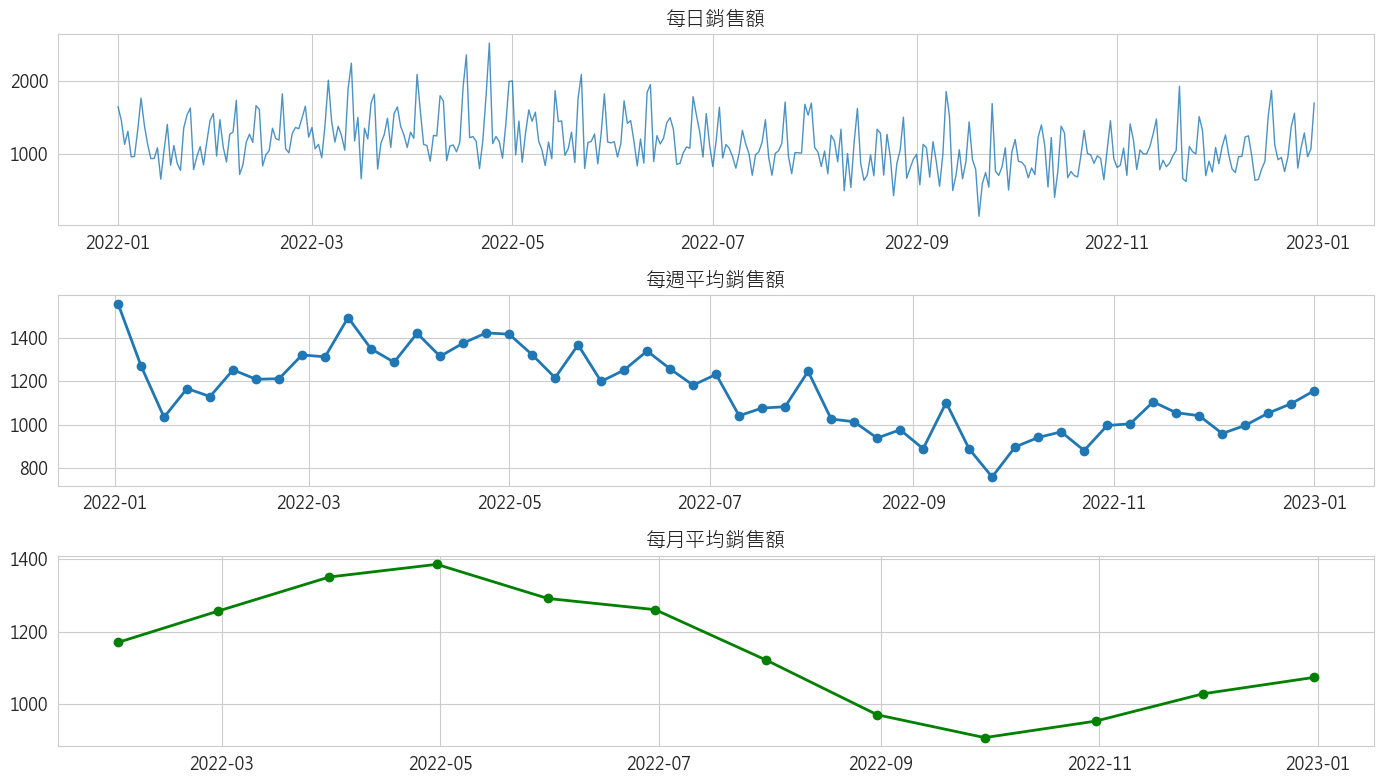

In [46]:
# 1.3 可視化不同頻率的數據
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(daily_sales.index, daily_sales.values, linewidth=1, alpha=0.8)
plt.title('每日銷售額')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(weekly_sales.index, weekly_sales.values, 'o-', linewidth=2)
plt.title('每週平均銷售額')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(monthly_sales.index, monthly_sales.values, 'o-', linewidth=2, color='green')
plt.title('每月平均銷售額')
plt.grid(True)

plt.tight_layout()
plt.show()

銷售額增長率:
            月增長率(%)  季增長率(%)
2022-01-31   -40.67      NaN
2022-02-28   -16.15      NaN
2022-03-31    -4.58   -21.01
2022-04-30    63.36      NaN
2022-05-31   -42.23      NaN
2022-06-30    -3.31    -7.02
2022-07-31   103.82      NaN
2022-08-31   -14.94      NaN
2022-09-30     3.22    23.87
2022-10-31   -21.30      NaN
2022-11-30    -7.59      NaN
2022-12-31    55.67    41.46


<Figure size 1200x600 with 0 Axes>

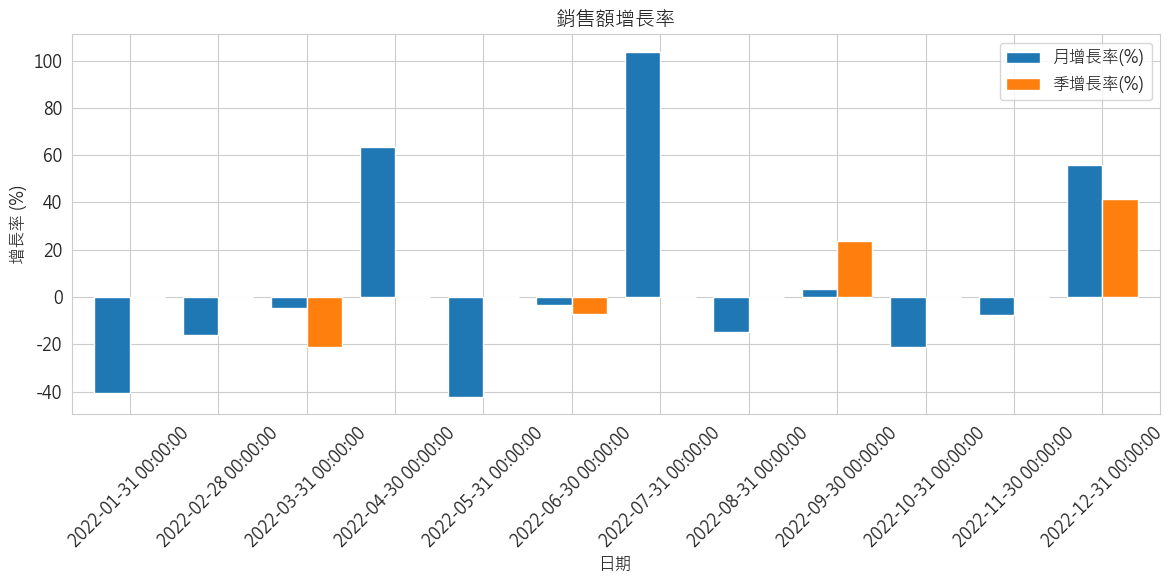

In [47]:
# 1.4 自定義重採樣聚合函數
# 創建一個計算收益率的函數
def calculate_returns(x):
    if len(x) >= 2:
        return (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100
    else:
        return 0

# 計算每月和每季度的增長率
returns = pd.DataFrame({
    '月增長率(%)': daily_sales.resample('M').apply(calculate_returns),
    '季增長率(%)': daily_sales.resample('Q').apply(calculate_returns)
})

print("銷售額增長率:")
print(returns)

# 繪製增長率
plt.figure(figsize=(12, 6))
returns.plot(kind='bar', width=0.8)
plt.title('銷售額增長率')
plt.xlabel('日期')
plt.ylabel('增長率 (%)')
plt.grid(True, axis='y')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

原月度數據:
2022-01-31    10000
2022-02-28    12000
2022-03-31     9000
2022-04-30    11000
2022-05-31    14000
2022-06-30    18000
2022-07-31    19000
2022-08-31    16000
2022-09-30    14000
2022-10-31    12000
2022-11-30    10000
2022-12-31    13000
Freq: ME, Name: 月銷售額, dtype: int64

上採樣到每日 (前向填充) - 前10行:
2022-01-31    10000
2022-02-01    10000
2022-02-02    10000
2022-02-03    10000
2022-02-04    10000
2022-02-05    10000
2022-02-06    10000
2022-02-07    10000
2022-02-08    10000
2022-02-09    10000
Freq: D, Name: 月銷售額, dtype: int64

上採樣到每日 (線性插值) - 前10行:
2022-01-31   10000.00
2022-02-01   10071.43
2022-02-02   10142.86
2022-02-03   10214.29
2022-02-04   10285.71
2022-02-05   10357.14
2022-02-06   10428.57
2022-02-07   10500.00
2022-02-08   10571.43
2022-02-09   10642.86
Freq: D, Name: 月銷售額, dtype: float64


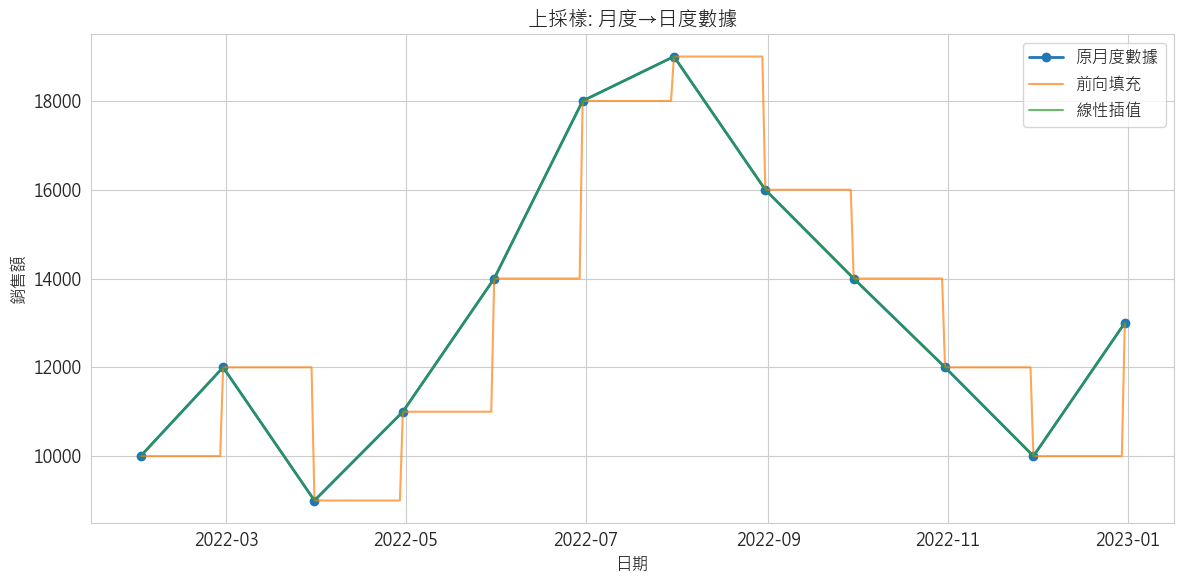

In [48]:
# 1.5 上採樣 (Upsampling) - 將低頻數據轉換為高頻數據
# 創建一個月度數據
monthly_data = pd.Series([
    10000, 12000, 9000, 11000, 14000, 18000, 
    19000, 16000, 14000, 12000, 10000, 13000
], index=pd.date_range('2022-01-01', periods=12, freq='M'), name='月銷售額')

print("原月度數據:")
print(monthly_data)

# 1.5.1 上採樣到日頻率，使用前向填充 (forward fill)
daily_ffill = monthly_data.resample('D').ffill()
print("\n上採樣到每日 (前向填充) - 前10行:")
print(daily_ffill.head(10))

# 1.5.2 上採樣到日頻率，使用插值 (interpolation)
daily_interp = monthly_data.resample('D').interpolate(method='linear')
print("\n上採樣到每日 (線性插值) - 前10行:")
print(daily_interp.head(10))

# 1.5.3 可視化上採樣結果
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data.values, 'o-', label='原月度數據', linewidth=2)
plt.plot(daily_ffill.index, daily_ffill.values, '-', label='前向填充', alpha=0.7)
plt.plot(daily_interp.index, daily_interp.values, '-', label='線性插值', alpha=0.7)
plt.title('上採樣: 月度→日度數據')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# 1.6 處理重採樣中的時區和缺失值
# 創建帶有缺失值的時間序列
dates = pd.date_range('2022-01-01', '2022-01-31', freq='D')
data_with_nans = pd.Series(np.random.normal(100, 10, len(dates)), index=dates)
data_with_nans.iloc[[5, 10, 15, 20, 25]] = np.nan  # 設置一些缺失值

print("帶缺失值的時間序列:")
print(data_with_nans.head(10))
print(f"缺失值數量: {data_with_nans.isna().sum()}")

# 1.6.1 使用不同方法處理缺失值的重採樣
weekly_mean = data_with_nans.resample('W').mean()
weekly_sum = data_with_nans.resample('W').sum()


print("\n每週平均 (跳過缺失值):")
print(weekly_mean)
print("\n每週總和 (跳過缺失值):")
print(weekly_sum)


帶缺失值的時間序列:
2022-01-01    95.99
2022-01-02   102.24
2022-01-03   100.13
2022-01-04   100.98
2022-01-05    92.27
2022-01-06      NaN
2022-01-07   104.98
2022-01-08   114.51
2022-01-09   109.59
2022-01-10   121.53
Freq: D, dtype: float64
缺失值數量: 5

每週平均 (跳過缺失值):
2022-01-02    99.11
2022-01-09   103.74
2022-01-16   109.18
2022-01-23    97.02
2022-01-30   104.26
2022-02-06    95.31
Freq: W-SUN, dtype: float64

每週總和 (跳過缺失值):
2022-01-02   198.23
2022-01-09   622.46
2022-01-16   545.90
2022-01-23   582.10
2022-01-30   625.56
2022-02-06    95.31
Freq: W-SUN, dtype: float64


解說：
- `resample()` 方法是時間序列頻率轉換的關鍵，類似於 `groupby()` 但專門用於時間索引
- 下採樣 (Downsampling) 將高頻數據轉換為低頻，需要指定聚合方法如 mean(), sum(), max() 等
- 上採樣 (Upsampling) 將低頻數據轉換為高頻，需要插值或填充方法處理新產生的時間點
- 自定義聚合函數可以在 `resample()` 後使用 `apply()` 來實現更複雜的計算
- 處理缺失值時，可以使用 `skipna` 參數控制是否忽略缺失值
- 在數據分析中，合理選擇重採樣的頻率和方法對結果有重大影響


## 📊 2. 移動窗口計算

移動窗口計算是時間序列分析中的常見操作，通過在連續的時間窗口上應用計算，可以捕捉數據的變化趨勢和模式。

In [50]:
# 2.1 創建示例時間序列數據
np.random.seed(42)
dates = pd.date_range('2022-01-01', '2022-12-31', freq='B')  # 工作日

# 創建模擬股票價格數據
price = 100
prices = [price]
for _ in range(1, len(dates)):
    change = np.random.normal(0, 1)
    price *= (1 + change/100)
    prices.append(price)

stock_prices = pd.Series(prices, index=dates, name='股價')
print("股票價格數據 (前10行):")
print(stock_prices.head(10))

股票價格數據 (前10行):
2022-01-03   100.00
2022-01-04   100.50
2022-01-05   100.36
2022-01-06   101.01
2022-01-07   102.55
2022-01-10   102.31
2022-01-11   102.07
2022-01-12   103.68
2022-01-13   104.47
2022-01-14   103.98
Freq: B, Name: 股價, dtype: float64


移動平均價格:
             原始價格  5日移動平均  20日移動平均  60日移動平均
2022-01-03 100.00     NaN      NaN      NaN
2022-01-04 100.50     NaN      NaN      NaN
2022-01-05 100.36     NaN      NaN      NaN
2022-01-06 101.01     NaN      NaN      NaN
2022-01-07 102.55  100.88      NaN      NaN
2022-01-10 102.31  101.34      NaN      NaN
2022-01-11 102.07  101.66      NaN      NaN
2022-01-12 103.68  102.32      NaN      NaN
2022-01-13 104.47  103.01      NaN      NaN
2022-01-14 103.98  103.30      NaN      NaN


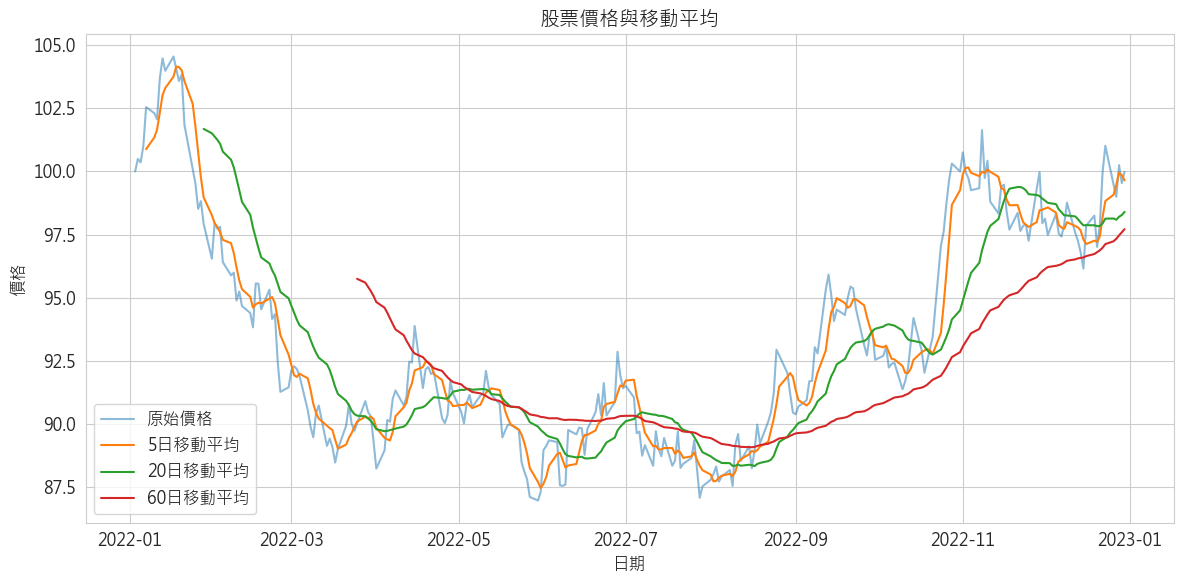

In [51]:
# 2.2 簡單移動平均 (Simple Moving Average, SMA)
# 計算不同窗口大小的移動平均
sma_5 = stock_prices.rolling(window=5).mean()  # 5日移動平均
sma_20 = stock_prices.rolling(window=20).mean()  # 20日移動平均
sma_60 = stock_prices.rolling(window=60).mean()  # 60日移動平均

# 將結果組合成DataFrame
moving_avgs = pd.DataFrame({
    '原始價格': stock_prices,
    '5日移動平均': sma_5,
    '20日移動平均': sma_20,
    '60日移動平均': sma_60
})

print("移動平均價格:")
print(moving_avgs.head(10))

# 繪製移動平均
plt.figure(figsize=(12, 6))
plt.plot(moving_avgs.index, moving_avgs['原始價格'], alpha=0.5, label='原始價格')
plt.plot(moving_avgs.index, moving_avgs['5日移動平均'], label='5日移動平均')
plt.plot(moving_avgs.index, moving_avgs['20日移動平均'], label='20日移動平均')
plt.plot(moving_avgs.index, moving_avgs['60日移動平均'], label='60日移動平均')
plt.title('股票價格與移動平均')
plt.xlabel('日期')
plt.ylabel('價格')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

20日滾動窗口統計量:
             原始價格  20日移動平均  20日標準差  20日最大值  20日最小值  20日中位數
2022-01-03 100.00      NaN     NaN     NaN     NaN     NaN
2022-01-04 100.50      NaN     NaN     NaN     NaN     NaN
2022-01-05 100.36      NaN     NaN     NaN     NaN     NaN
2022-01-06 101.01      NaN     NaN     NaN     NaN     NaN
2022-01-07 102.55      NaN     NaN     NaN     NaN     NaN
...           ...      ...     ...     ...     ...     ...
2022-01-31  96.54   101.51    2.40  104.55   96.54  101.95
2022-02-01  97.96   101.38    2.52  104.55   96.54  101.95
2022-02-02  97.74   101.25    2.64  104.55   96.54  101.95
2022-02-03  97.80   101.09    2.75  104.55   96.54  101.95
2022-02-04  96.41   100.79    2.92  104.55   96.41  100.96

[25 rows x 6 columns]

股票收益率和波動率:
            日收益率(%)  20日年化波動率(%)
2022-01-04     0.50          NaN
2022-01-05    -0.14          NaN
2022-01-06     0.65          NaN
2022-01-07     1.52          NaN
2022-01-10    -0.23          NaN
...             ...          ...
2022-02-01    

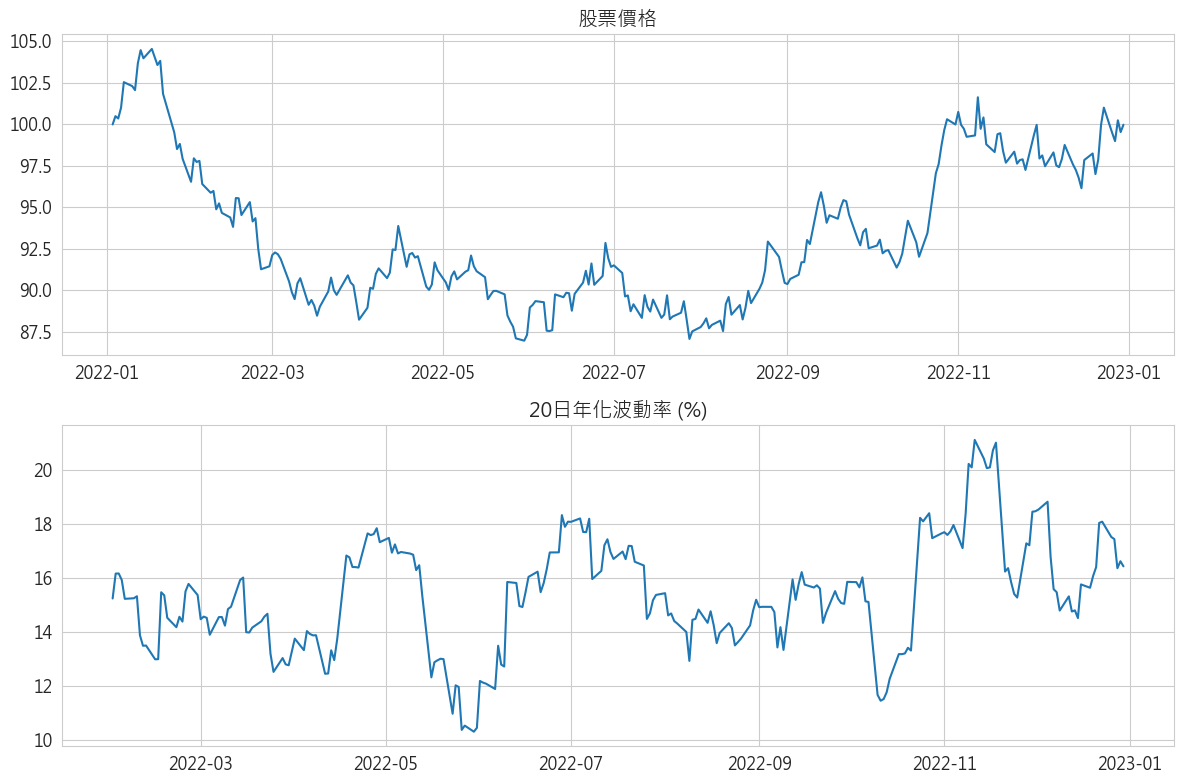

In [52]:
# 2.3 其他滾動窗口統計量
# 計算各種滾動統計量
rolling_stats = pd.DataFrame({
    '原始價格': stock_prices,
    '20日移動平均': stock_prices.rolling(window=20).mean(),
    '20日標準差': stock_prices.rolling(window=20).std(),
    '20日最大值': stock_prices.rolling(window=20).max(),
    '20日最小值': stock_prices.rolling(window=20).min(),
    '20日中位數': stock_prices.rolling(window=20).median()
})

print("20日滾動窗口統計量:")
print(rolling_stats.head(25))

# 2.4 計算移動波動率
stock_returns = stock_prices.pct_change().dropna()  # 計算日收益率
volatility_20 = stock_returns.rolling(window=20).std() * np.sqrt(252)  # 年化波動率 (假設252個交易日)

print("\n股票收益率和波動率:")
print(pd.DataFrame({
    '日收益率(%)': stock_returns * 100,
    '20日年化波動率(%)': volatility_20 * 100
}).head(25))

# 可視化波動率
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(stock_prices.index, stock_prices.values)
plt.title('股票價格')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(volatility_20.index, volatility_20.values * 100)
plt.title('20日年化波動率 (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

指數加權移動平均:
             原始價格  5日EWMA  20日EWMA  60日EWMA
2022-01-03 100.00  100.00   100.00   100.00
2022-01-04 100.50  100.30   100.26   100.25
2022-01-05 100.36  100.33   100.30   100.29
2022-01-06 101.01  100.61   100.50   100.48
2022-01-07 102.55  101.35   101.00   100.92
2022-01-10 102.31  101.70   101.27   101.17
2022-01-11 102.07  101.83   101.42   101.31
2022-01-12 103.68  102.47   101.81   101.64
2022-01-13 104.47  103.16   102.24   102.00
2022-01-14 103.98  103.44   102.50   102.23


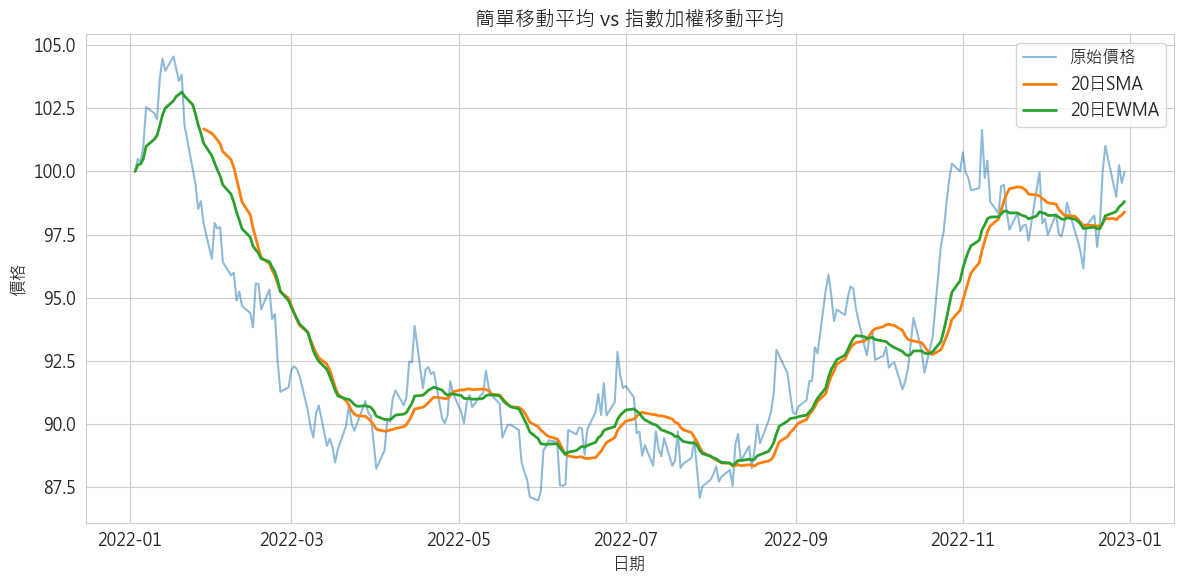

In [53]:
# 2.5 指數加權移動平均 (Exponential Weighted Moving Average, EWMA)
# 計算不同窗口大小對應的指數加權移動平均
# span參數關係到平滑因子α: α = 2/(span+1)
ewma_5 = stock_prices.ewm(span=5).mean()  # 等效於5日SMA
ewma_20 = stock_prices.ewm(span=20).mean()  # 等效於20日SMA
ewma_60 = stock_prices.ewm(span=60).mean()  # 等效於60日SMA

# 將結果組合成DataFrame
ewma_df = pd.DataFrame({
    '原始價格': stock_prices,
    '5日EWMA': ewma_5,
    '20日EWMA': ewma_20,
    '60日EWMA': ewma_60
})

print("指數加權移動平均:")
print(ewma_df.head(10))

# 比較SMA和EWMA
plt.figure(figsize=(12, 6))
plt.plot(stock_prices.index, stock_prices.values, alpha=0.5, label='原始價格')
plt.plot(sma_20.index, sma_20.values, label='20日SMA', linewidth=2)
plt.plot(ewma_20.index, ewma_20.values, label='20日EWMA', linewidth=2)
plt.title('簡單移動平均 vs 指數加權移動平均')
plt.xlabel('日期')
plt.ylabel('價格')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

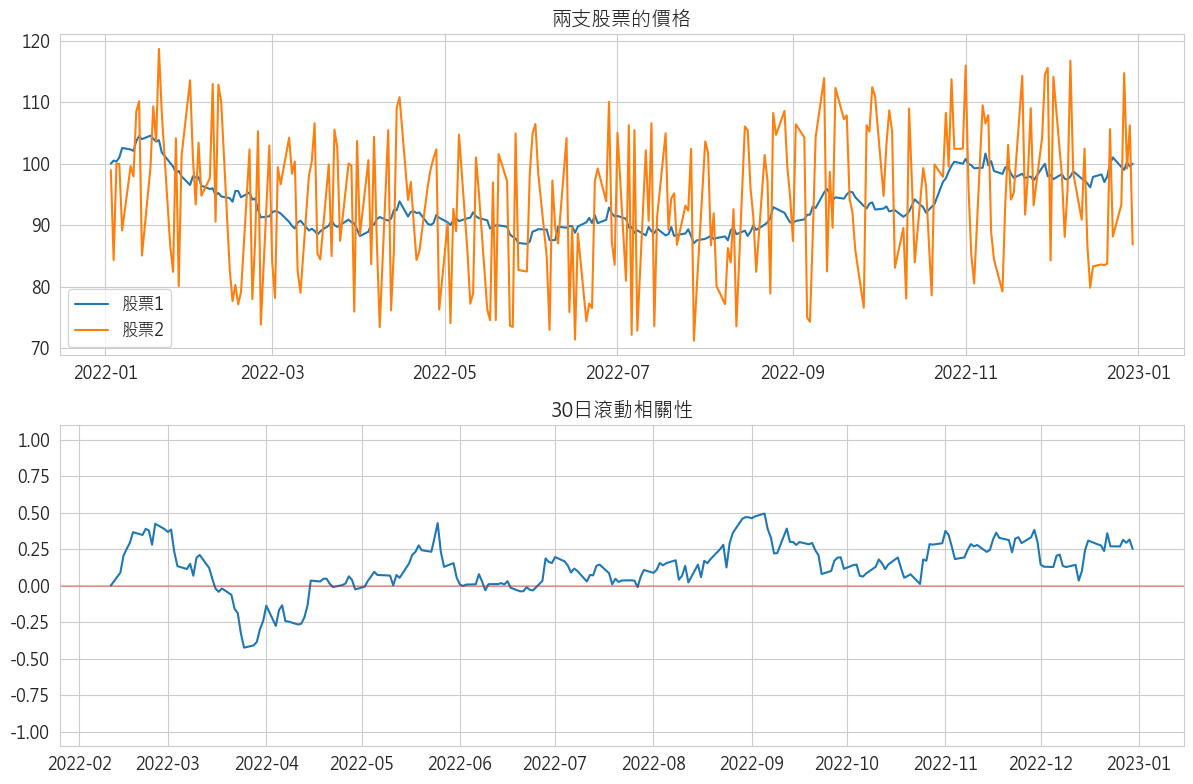

In [54]:
# 2.6 滾動窗口相關性
# 創建另一個股票價格序列 (稍微相關)
stock2_prices = stock_prices * (0.8 + 0.4 * np.random.random(len(stock_prices)))

# 計算滾動相關性
rolling_corr = stock_prices.rolling(window=30).corr(stock2_prices)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(stock_prices.index, stock_prices.values, label='股票1')
plt.plot(stock2_prices.index, stock2_prices.values, label='股票2')
plt.title('兩支股票的價格')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_corr.index, rolling_corr.values)
plt.title('30日滾動相關性')
plt.ylim(-1.1, 1.1)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()


60日滾動夏普比率:
2022-01-03     NaN
2022-01-04     NaN
2022-01-05     NaN
2022-01-06     NaN
2022-01-07     NaN
              ... 
2022-03-28   -2.88
2022-03-29   -2.98
2022-03-30   -3.25
2022-03-31   -4.13
2022-04-01   -4.37
Freq: B, Name: 股價, Length: 65, dtype: float64


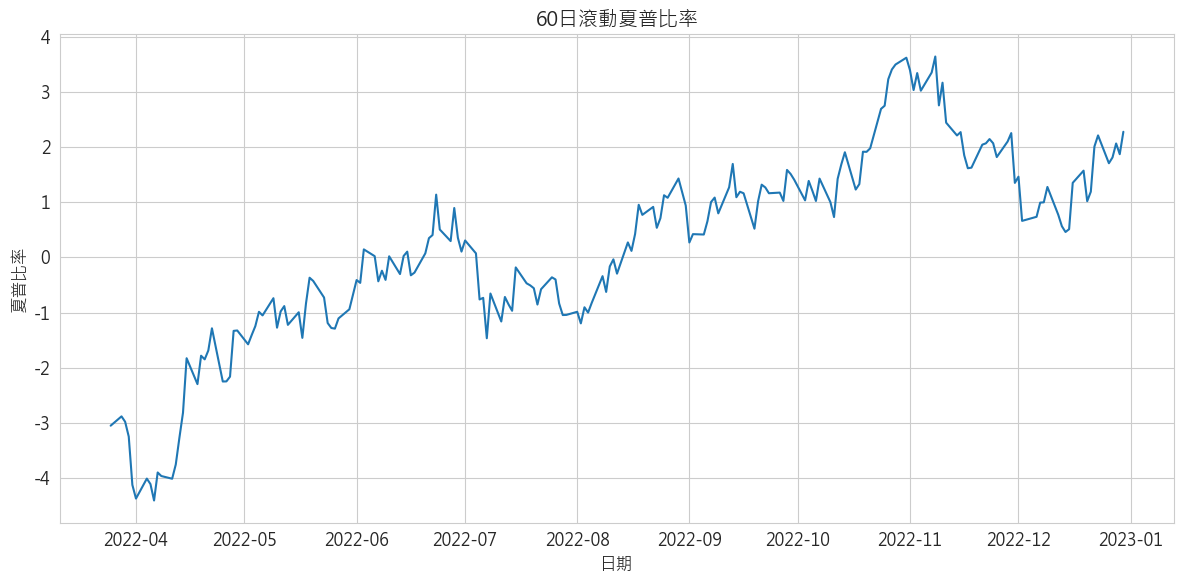

In [55]:
# 2.7 自定義滾動窗口函數
# 定義一個計算風險調整收益率的函數
def sharpe_ratio(x):
    returns = x.pct_change().dropna()
    return (returns.mean() / returns.std()) * np.sqrt(252)  # 年化夏普比率

# 應用自定義函數到滾動窗口
rolling_sharpe = stock_prices.rolling(window=60).apply(sharpe_ratio)

print("\n60日滾動夏普比率:")
print(rolling_sharpe.head(65))

plt.figure(figsize=(12, 6))
plt.plot(rolling_sharpe.index, rolling_sharpe.values)
plt.title('60日滾動夏普比率')
plt.xlabel('日期')
plt.ylabel('夏普比率')
plt.grid(True)
plt.tight_layout()
plt.show()

解說：
- 移動窗口計算可以使用 `rolling()` 方法實現，常見操作包括計算均值、標準差、最大/最小值等
- 窗口大小 (window) 是關鍵參數，決定了考慮多少個過去的觀測值
- 指數加權移動平均 (EWMA) 通過 `ewm()` 方法實現，給予近期數據更高的權重
- 滾動窗口可以應用於單個時間序列 (如移動平均) 或多個時間序列間的關係 (如滾動相關性)
- 可以使用 `apply()` 方法應用自定義函數到滾動窗口，處理複雜的指標計算
- 移動窗口技術在金融分析中尤其有用，可以用於識別趨勢、計算技術指標和風險度量


## 📊 3. 季節性分解

季節性分解是將時間序列分解為趨勢、季節性和殘差組件的技術，有助於理解數據的本質模式和結構。

模擬銷售數據 (前10行):
2021-01-01   102.48
2021-01-02   103.52
2021-01-03   108.71
2021-01-04   110.68
2021-01-05    97.86
2021-01-06    95.45
2021-01-07   105.78
2021-01-08   105.93
2021-01-09   103.95
2021-01-10   110.27
Freq: D, Name: 銷售額, dtype: float64


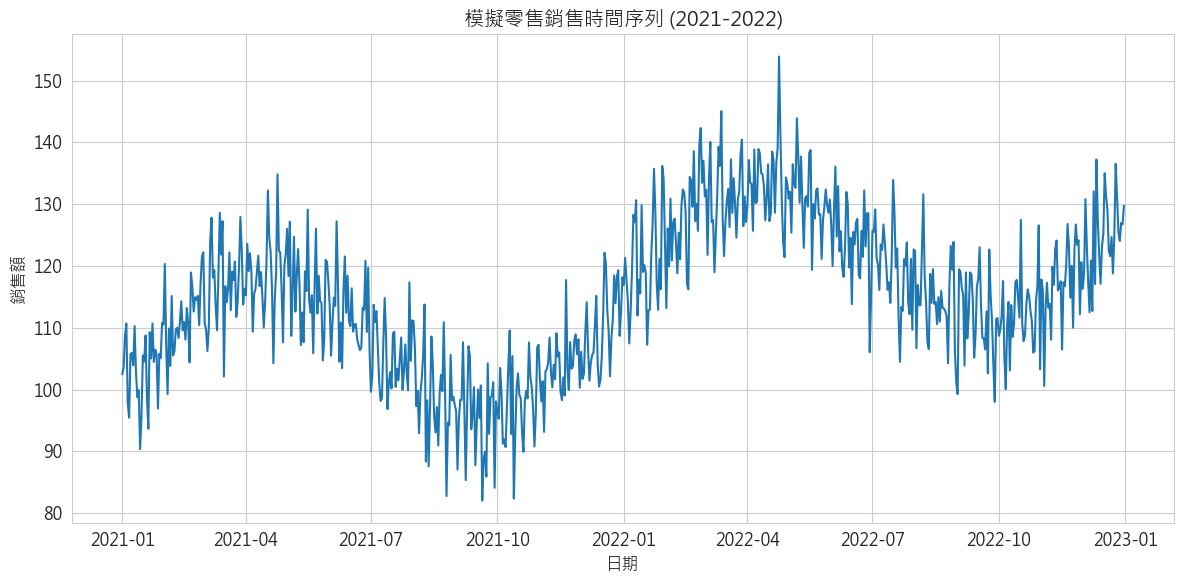

In [56]:
# 3.1 創建具有明顯季節性的時間序列數據
# 創建2年的模擬零售銷售數據
np.random.seed(42)
dates = pd.date_range('2021-01-01', '2022-12-31', freq='D')
n = len(dates)

# 趨勢成分 (線性增長)
trend = np.linspace(0, 30, n)

# 季節性成分 (年度和週度)
annual_seasonality = 15 * np.sin(2 * np.pi * np.arange(n) / 365)  # 年度季節性 (振幅15)
weekly_seasonality = 5 * np.sin(2 * np.pi * np.arange(n) / 7)     # 週度季節性 (振幅5)
seasonality = annual_seasonality + weekly_seasonality

# 隨機噪聲
noise = np.random.normal(0, 5, n)

# 組合成數據
sales = 100 + trend + seasonality + noise
sales_ts = pd.Series(sales, index=dates, name='銷售額')

print("模擬銷售數據 (前10行):")
print(sales_ts.head(10))

# 可視化原始數據
plt.figure(figsize=(12, 6))
plt.plot(sales_ts.index, sales_ts.values)
plt.title('模擬零售銷售時間序列 (2021-2022)')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.grid(True)
plt.tight_layout()
plt.show()

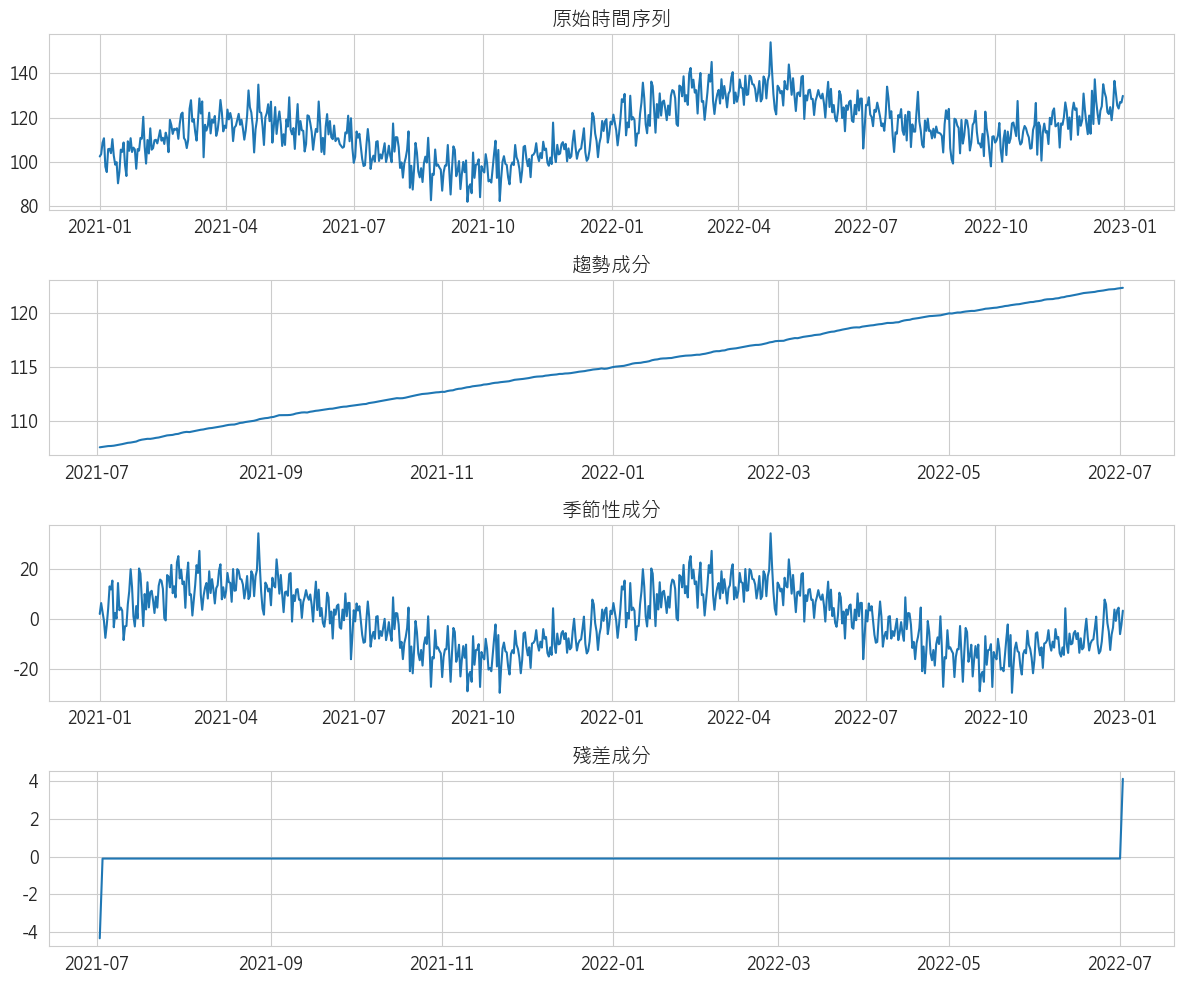

In [57]:
# 3.2 加法季節性分解
# 使用 seasonal_decompose 進行加法分解
decomposition_add = seasonal_decompose(sales_ts, model='additive', period=365)

trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

# 可視化加法分解結果
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sales_ts.index, sales_ts.values)
plt.title('原始時間序列')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(trend.index, trend.values)
plt.title('趨勢成分')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(seasonal.index, seasonal.values)
plt.title('季節性成分')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(residual.index, residual.values)
plt.title('殘差成分')
plt.grid(True)

plt.tight_layout()
plt.show()

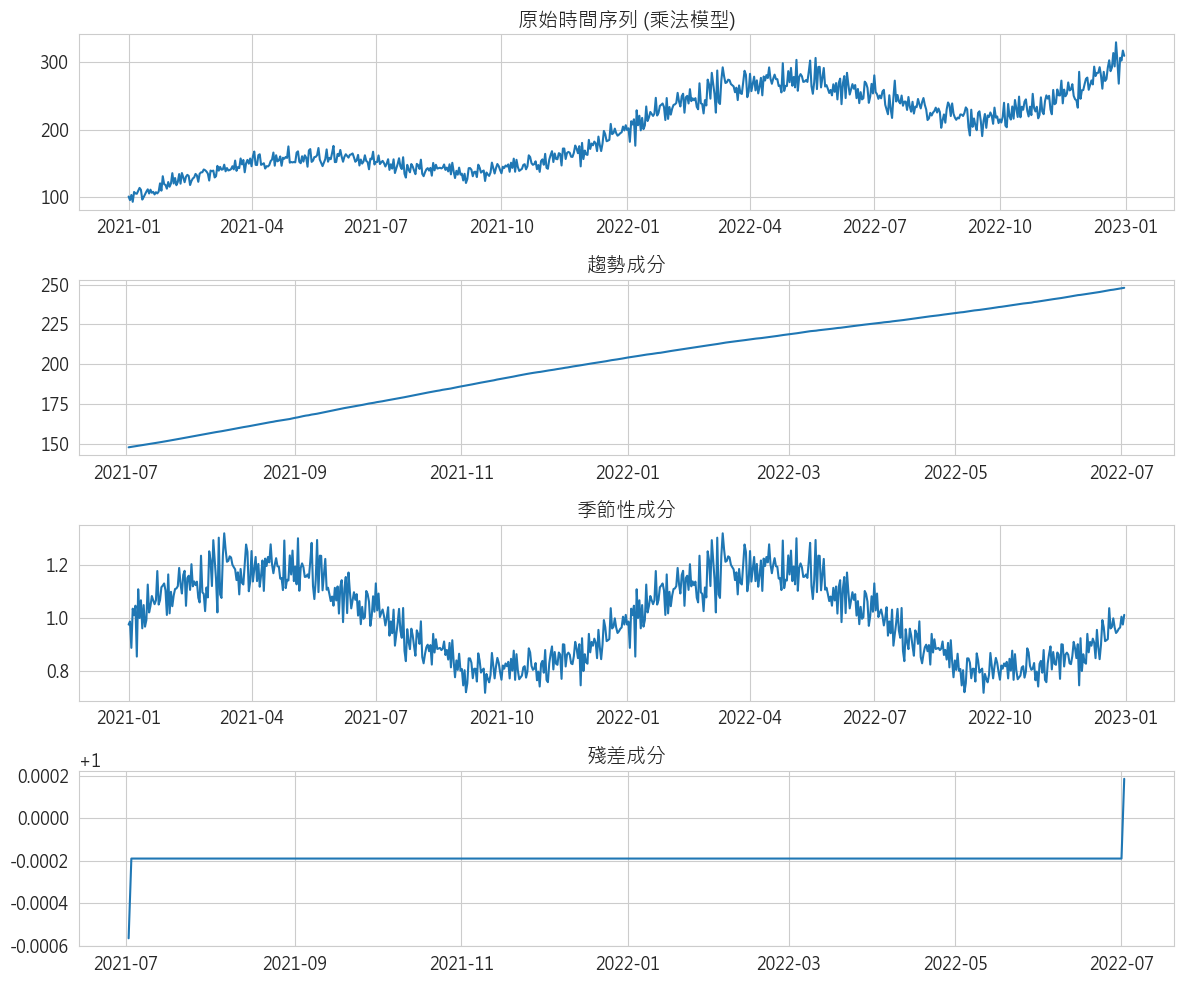

In [58]:
# 3.3 乘法季節性分解
# 創建具有乘法特性的時間序列
# 趨勢和季節性振幅成正比的數據
trend_mult = np.linspace(100, 300, n)  # 趨勢從100增長到300
seasonal_factor = 1 + 0.2 * np.sin(2 * np.pi * np.arange(n) / 365)  # 季節性因子 (±20%)
noise_factor = 1 + 0.05 * np.random.randn(n)  # 隨機噪聲 (±5%)

# 乘法模型：各成分相乘
sales_mult = trend_mult * seasonal_factor * noise_factor
sales_mult_ts = pd.Series(sales_mult, index=dates, name='銷售額(乘法)')

# 使用 seasonal_decompose 進行乘法分解
decomposition_mult = seasonal_decompose(sales_mult_ts, model='multiplicative', period=365)

trend_mult = decomposition_mult.trend
seasonal_mult = decomposition_mult.seasonal
residual_mult = decomposition_mult.resid

# 可視化乘法分解結果
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sales_mult_ts.index, sales_mult_ts.values)
plt.title('原始時間序列 (乘法模型)')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(trend_mult.index, trend_mult.values)
plt.title('趨勢成分')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(seasonal_mult.index, seasonal_mult.values)
plt.title('季節性成分')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(residual_mult.index, residual_mult.values)
plt.title('殘差成分')
plt.grid(True)

plt.tight_layout()
plt.show()

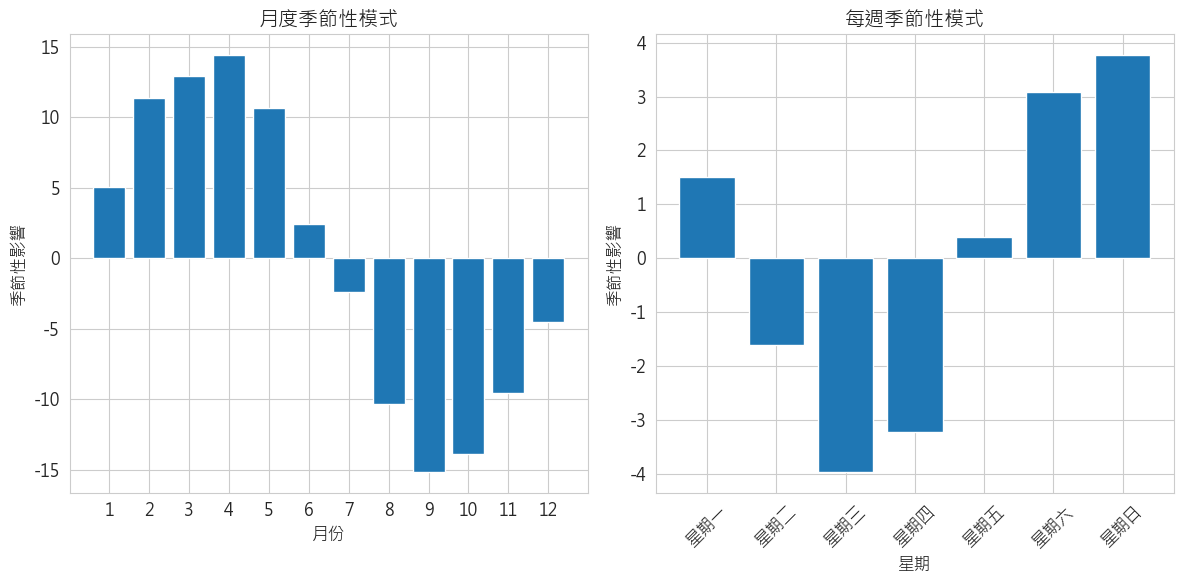

In [59]:
# 3.4 觀察季節性模式
# 計算平均季節性模式 (按月和按星期幾)
monthly_seasonal = seasonal.groupby(seasonal.index.month).mean()
weekday_seasonal = seasonal.groupby(seasonal.index.dayofweek).mean()

# 可視化月度季節性模式
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, 13), monthly_seasonal.values)
plt.title('月度季節性模式')
plt.xlabel('月份')
plt.ylabel('季節性影響')
plt.xticks(range(1, 13))
plt.grid(True, axis='y')

# 可視化每週季節性模式
plt.subplot(1, 2, 2)
days = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日']
plt.bar(days, weekday_seasonal.values)
plt.title('每週季節性模式')
plt.xlabel('星期')
plt.ylabel('季節性影響')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

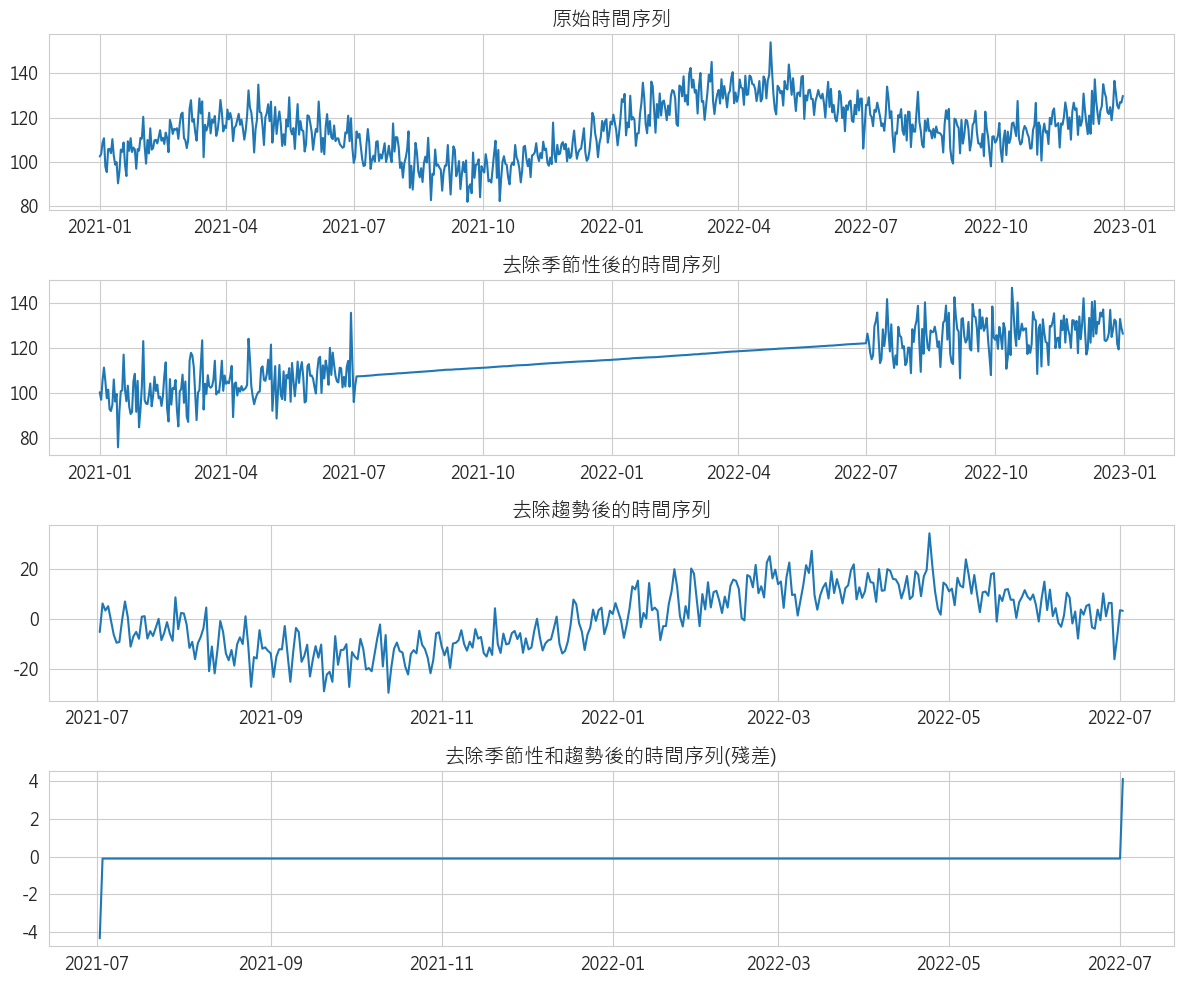

In [60]:
# 3.5 去除季節性和趨勢
# 使用加法模型去除季節性和趨勢
deseasonalized = sales_ts - seasonal
detrended = sales_ts - trend
adjusted = sales_ts - seasonal - trend

# 可視化去除成分後的數據
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sales_ts.index, sales_ts.values)
plt.title('原始時間序列')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(deseasonalized.index, deseasonalized.values)
plt.title('去除季節性後的時間序列')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(detrended.index, detrended.values)
plt.title('去除趨勢後的時間序列')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(adjusted.index, adjusted.values)
plt.title('去除季節性和趨勢後的時間序列(殘差)')
plt.grid(True)

plt.tight_layout()
plt.show()

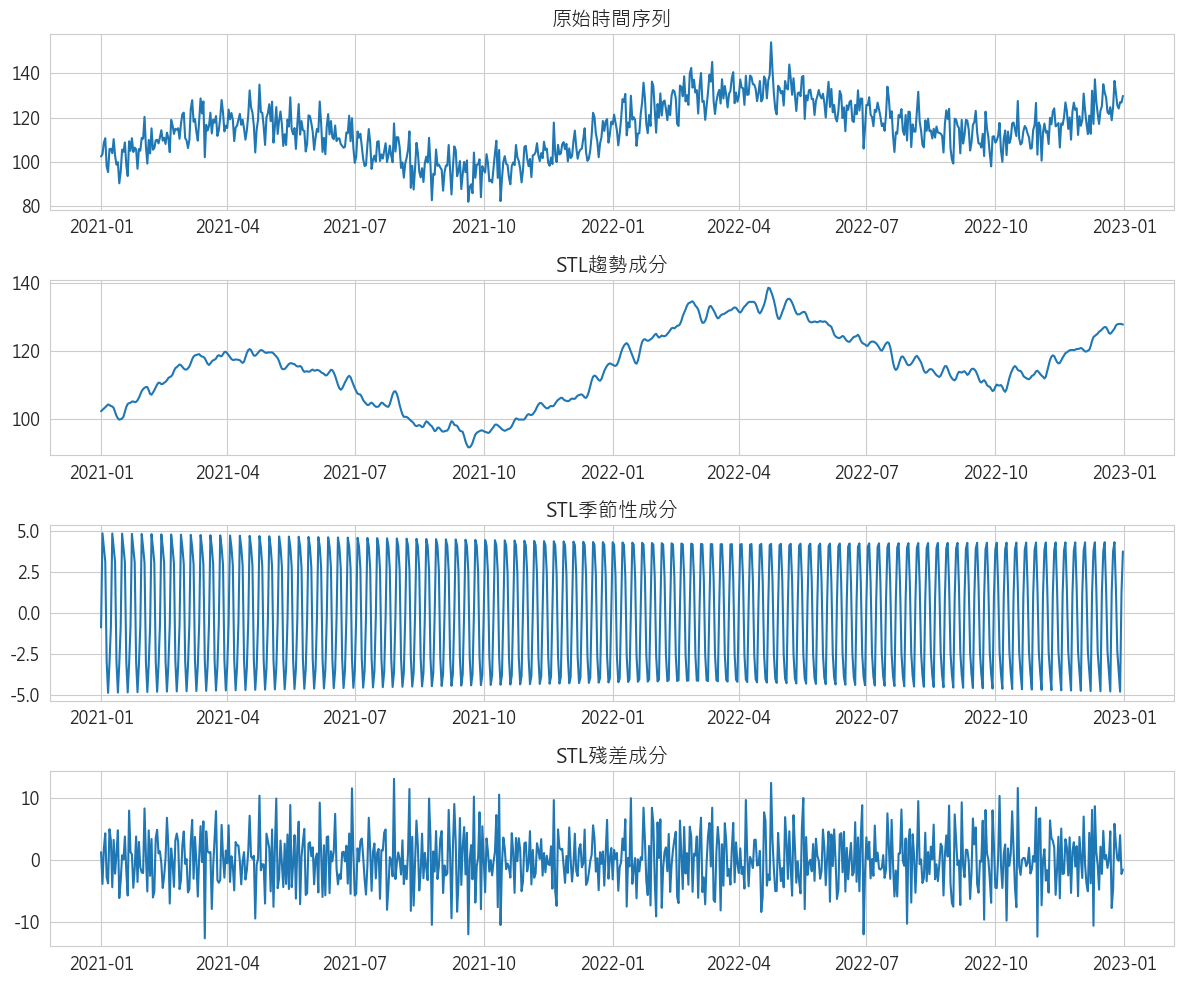

In [61]:
# 3.6 使用STL分解 (Seasonal and Trend decomposition using Loess)
# STL分解比標準的seasonal_decompose更靈活，可以處理複雜的季節性
stl = sm.tsa.STL(sales_ts, seasonal=365, trend=None).fit()
stl_trend = stl.trend
stl_seasonal = stl.seasonal
stl_resid = stl.resid

# 可視化STL分解結果
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(sales_ts.index, sales_ts.values)
plt.title('原始時間序列')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(stl_trend.index, stl_trend.values)
plt.title('STL趨勢成分')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(stl_seasonal.index, stl_seasonal.values)
plt.title('STL季節性成分')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(stl_resid.index, stl_resid.values)
plt.title('STL殘差成分')
plt.grid(True)

plt.tight_layout()
plt.show()

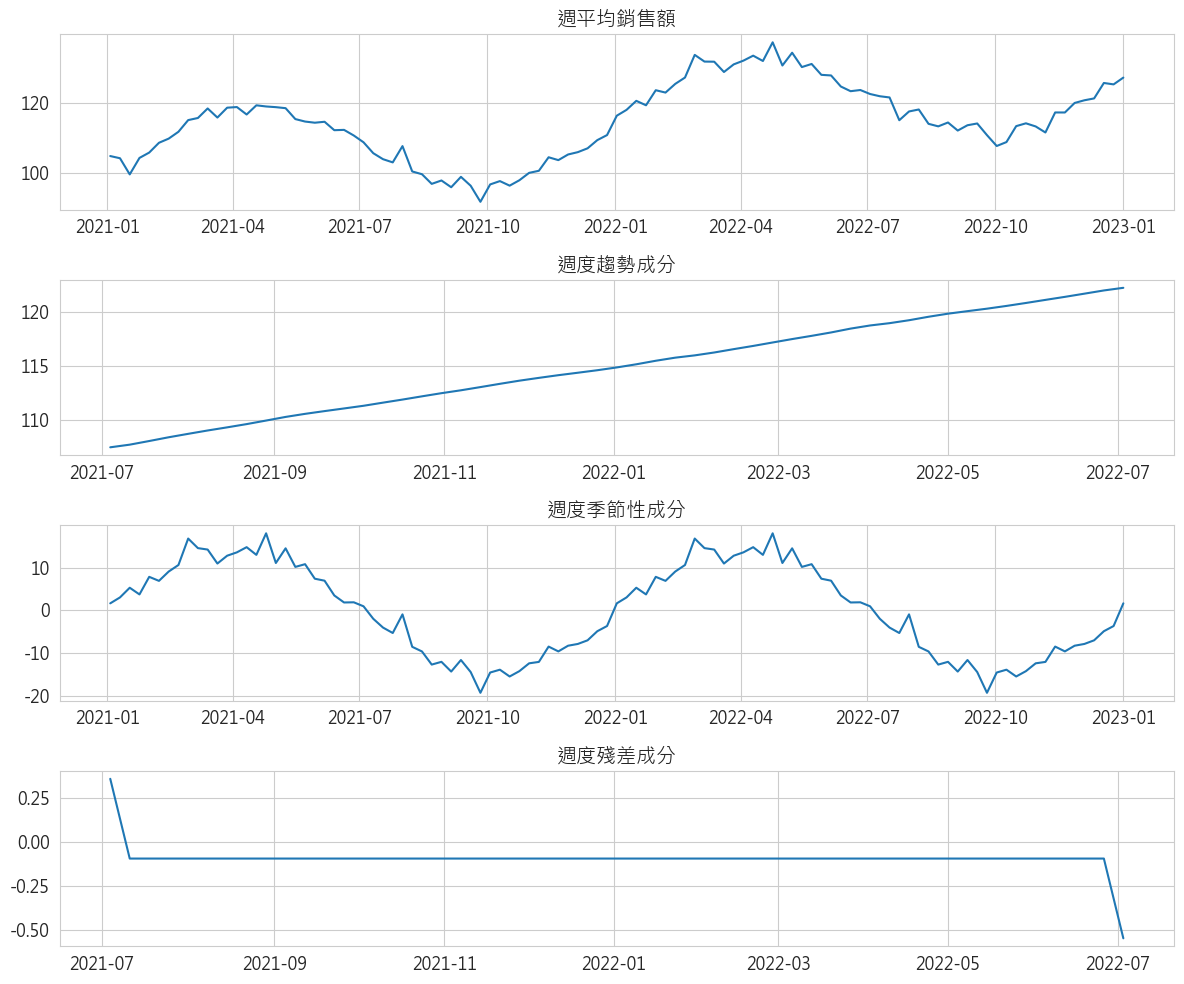

In [62]:
# 3.7 多重季節性分解
# 重採樣到週頻率以便觀察年度季節性
weekly_sales = sales_ts.resample('W').mean()
weekly_decomp = seasonal_decompose(weekly_sales, model='additive', period=52)  # 52週一年

# 可視化週度資料的年度季節性
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('週平均銷售額')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(weekly_decomp.trend.index, weekly_decomp.trend.values)
plt.title('週度趨勢成分')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(weekly_decomp.seasonal.index, weekly_decomp.seasonal.values)
plt.title('週度季節性成分')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(weekly_decomp.resid.index, weekly_decomp.resid.values)
plt.title('週度殘差成分')
plt.grid(True)

plt.tight_layout()
plt.show()

解說：
- 季節性分解可將時間序列分為三個主要成分：趨勢、季節性和殘差
- 趨勢成分反映數據的長期走向，季節性成分反映週期性變化，殘差成分包含隨機波動
- 加法模型適用於季節性振幅相對恆定的數據：Y = Trend + Seasonality + Residual
- 乘法模型適用於季節性振幅隨趨勢變化的數據：Y = Trend * Seasonality * Residual
- 季節性分解有助於理解數據中的模式，去除季節性和趨勢有助於進行進一步分析
- STL分解比標準分解更靈活，可以處理更複雜的季節性模式
- 多重季節性分解可以分析數據中存在的不同時間尺度的季節性


## 📊 4. 時間序列預測

時間序列預測是利用歷史數據來預測未來值的技術。本節將介紹幾種常見的時間序列預測方法。

訓練集大小: 76
測試集大小: 20


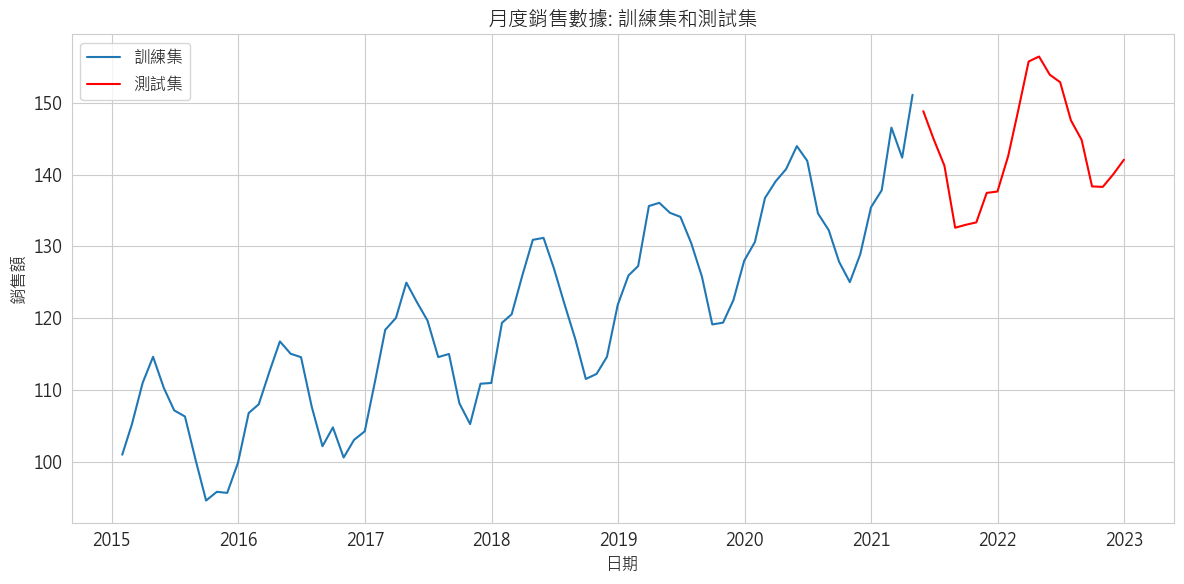

In [63]:
# 4.1 準備預測數據
# 使用具有趨勢和季節性的模擬月度銷售數據
np.random.seed(42)
dates = pd.date_range('2015-01-01', '2022-12-31', freq='M')
n = len(dates)

# 生成時間序列組件
trend = np.linspace(0, 50, n)  # 線性趨勢
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 12)  # 年度季節性
noise = np.random.normal(0, 2, n)  # 隨機噪聲

# 生成月度銷售數據
monthly_sales = pd.Series(100 + trend + seasonality + noise, index=dates, name='月銷售額')

# 劃分訓練集和測試集
train_size = int(len(monthly_sales) * 0.8)
train = monthly_sales[:train_size]
test = monthly_sales[train_size:]

print(f"訓練集大小: {len(train)}")
print(f"測試集大小: {len(test)}")

# 可視化訓練集和測試集
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='訓練集')
plt.plot(test.index, test.values, label='測試集', color='red')
plt.title('月度銷售數據: 訓練集和測試集')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
train.iloc[-1]

151.11748921927673

朴素預測法 MSE: 110.97
季節性朴素法 MSE: 40.48
簡單移動平均預測 MSE: 91.84


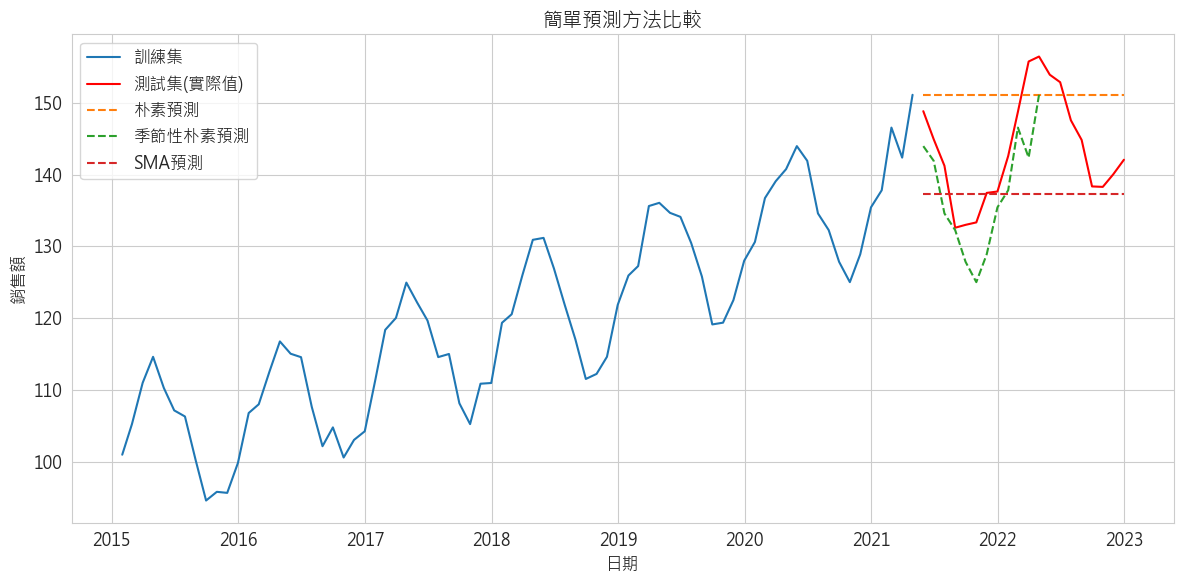

In [68]:
# 4.2 簡單預測方法
# 4.2.1 朴素預測法 (假設未來值等於最後一個觀測值)
naive_pred = pd.Series(train.iloc[-1], index=test.index, name='朴素預測')

# 4.2.2 季節性朴素法 (使用一年前的相同月份作為預測)
seasonal_pred = pd.Series()
for i in range(len(test)):
    month_to_predict = test.index[i].month
    year_to_predict = test.index[i].year
    # 找到訓練集中前一年的相同月份
    prev_year_data = train[
        (train.index.month == month_to_predict) & 
        (train.index.year == year_to_predict - 1)
    ]
    if not prev_year_data.empty:
        seasonal_pred[test.index[i]] = prev_year_data.iloc[0]
    else:
        seasonal_pred[test.index[i]] = np.nan  # 如果找不到匹配的月份

# 4.2.3 簡單移動平均預測
window_size = 12  # 使用過去12個月的平均值
sma_last = train.rolling(window=window_size).mean().iloc[-1]
sma_pred = pd.Series(sma_last, index=test.index, name='SMA預測')

# 計算每種方法的誤差
naive_mse = mean_squared_error(test, naive_pred)

# 找出 seasonal_pred 和 test 同時存在的時間點
valid_index = seasonal_pred.dropna().index.intersection(test.index)
# 僅針對這些 index 評估 MSE
seasonal_mse = mean_squared_error(test.loc[valid_index], seasonal_pred.loc[valid_index])

sma_mse = mean_squared_error(test, sma_pred)

print(f"朴素預測法 MSE: {naive_mse:.2f}")
print(f"季節性朴素法 MSE: {seasonal_mse:.2f}")
print(f"簡單移動平均預測 MSE: {sma_mse:.2f}")

# 可視化簡單預測方法結果
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='訓練集')
plt.plot(test.index, test.values, label='測試集(實際值)', color='red')
plt.plot(test.index, naive_pred.values, label='朴素預測', linestyle='--')
plt.plot(test.index, seasonal_pred.values, label='季節性朴素預測', linestyle='--')
plt.plot(test.index, sma_pred.values, label='SMA預測', linestyle='--')
plt.title('簡單預測方法比較')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

簡單指數平滑法 MSE: 54.14
霍爾特指數平滑法 MSE: 184.41
霍爾特-溫特斯加法模型 MSE: 3.68
霍爾特-溫特斯乘法模型 MSE: 4.94


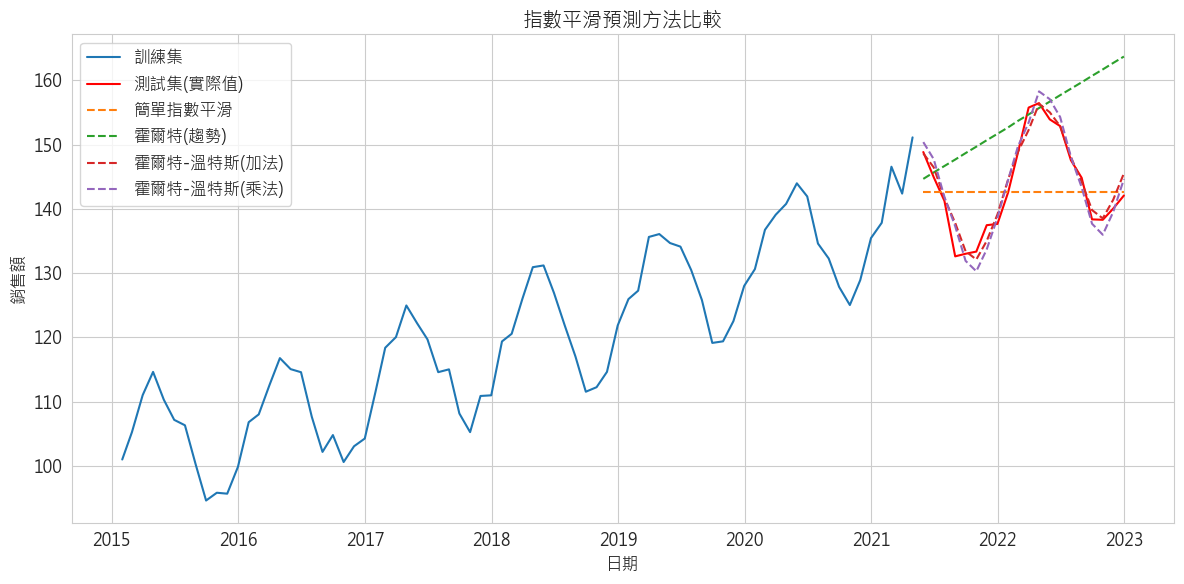

In [69]:
# 4.3 指數平滑法
# 4.3.1 簡單指數平滑法 (SES)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.3)
ses_pred = ses_model.forecast(len(test))
ses_mse = mean_squared_error(test, ses_pred)
print(f"簡單指數平滑法 MSE: {ses_mse:.2f}")

# 4.3.2 霍爾特指數平滑法 (處理趨勢)
from statsmodels.tsa.holtwinters import Holt
holt_model = Holt(train).fit(smoothing_level=0.3, smoothing_trend=0.1)
holt_pred = holt_model.forecast(len(test))
holt_mse = mean_squared_error(test, holt_pred)
print(f"霍爾特指數平滑法 MSE: {holt_mse:.2f}")

# 4.3.3 霍爾特-溫特斯指數平滑法 (處理趨勢和季節性)
# 加法模型
hw_add_model = ExponentialSmoothing(
    train, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()
hw_add_pred = hw_add_model.forecast(len(test))
hw_add_mse = mean_squared_error(test, hw_add_pred)
print(f"霍爾特-溫特斯加法模型 MSE: {hw_add_mse:.2f}")

# 乘法模型
hw_mult_model = ExponentialSmoothing(
    train, 
    trend='add', 
    seasonal='mul', 
    seasonal_periods=12
).fit()
hw_mult_pred = hw_mult_model.forecast(len(test))
hw_mult_mse = mean_squared_error(test, hw_mult_pred)
print(f"霍爾特-溫特斯乘法模型 MSE: {hw_mult_mse:.2f}")

# 可視化指數平滑法結果
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='訓練集')
plt.plot(test.index, test.values, label='測試集(實際值)', color='red')
plt.plot(test.index, ses_pred.values, label='簡單指數平滑', linestyle='--')
plt.plot(test.index, holt_pred.values, label='霍爾特(趨勢)', linestyle='--')
plt.plot(test.index, hw_add_pred.values, label='霍爾特-溫特斯(加法)', linestyle='--')
plt.plot(test.index, hw_mult_pred.values, label='霍爾特-溫特斯(乘法)', linestyle='--')
plt.title('指數平滑預測方法比較')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

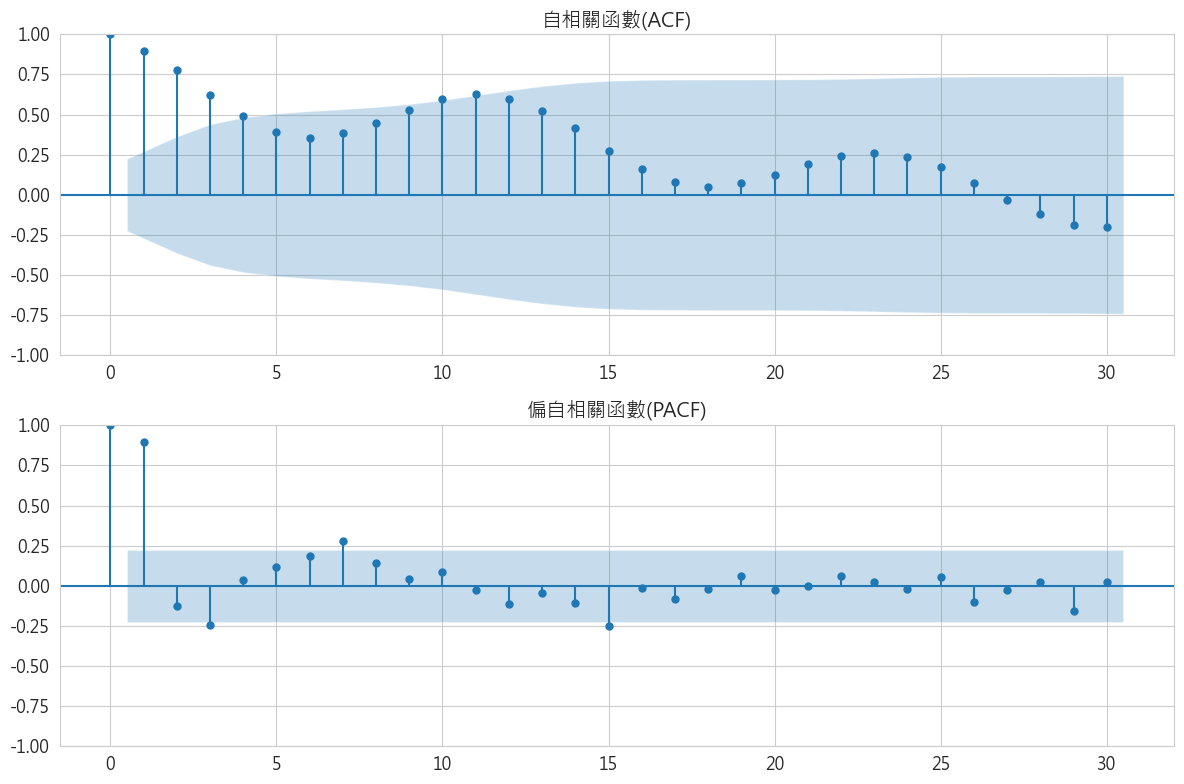

ARIMA模型 MSE: 20.08

ARIMA模型摘要:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7320      0.008    218.878      0.000       1.717       1.748
ar.L2         -1.0000      0.000  -2760.900      0.000      -1.001      -0.999
ma.L1         -1.7308      0.151    -11.434      0.000      -2.027      -1.434
ma.L2          1.0000      0.187      5.352      0.000       0.634       1.366
sigma2         7.8666      0.038    209.175      0.000       7.793       7.940
SARIMA模型 MSE: 8.04


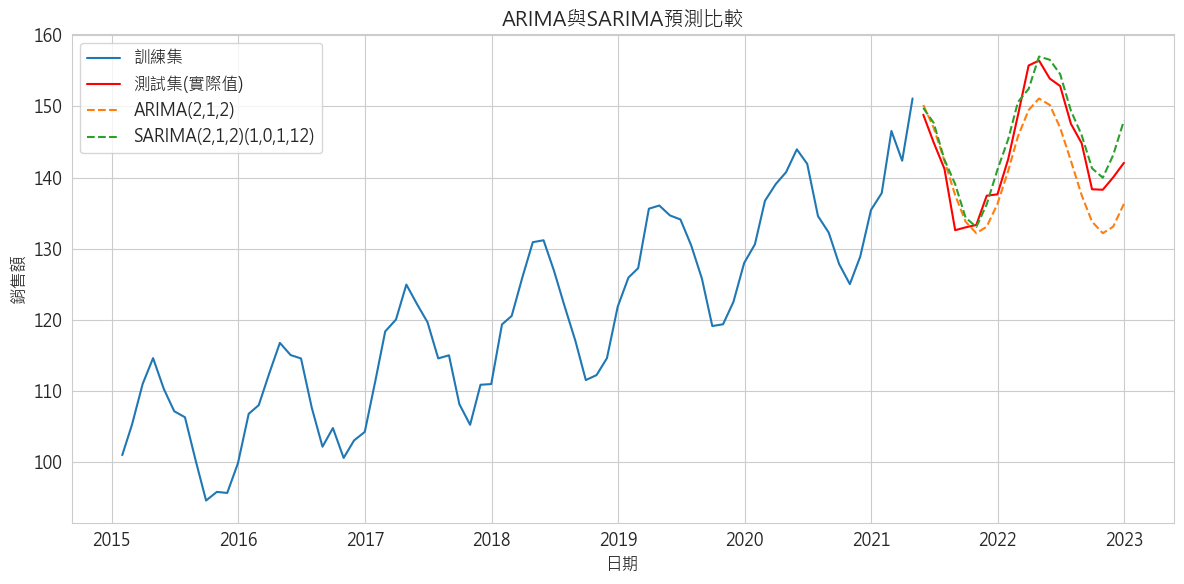

In [70]:
# 4.4 ARIMA模型 (自迴歸整合移動平均)
# 4.4.1 觀察數據的自相關性和偏自相關性
plt.figure(figsize=(12, 8))
plot_acf(train, lags=30, ax=plt.subplot(211))
plt.title('自相關函數(ACF)')
plot_pacf(train, lags=30, ax=plt.subplot(212))
plt.title('偏自相關函數(PACF)')
plt.tight_layout()
plt.show()

# 4.4.2 擬合ARIMA模型
from statsmodels.tsa.arima.model import ARIMA
# 基於ACF和PACF選擇的參數 (p, d, q) = (2, 1, 2)
arima_model = ARIMA(train, order=(2, 1, 2)).fit()
arima_pred = arima_model.forecast(len(test))
arima_mse = mean_squared_error(test, arima_pred)
print(f"ARIMA模型 MSE: {arima_mse:.2f}")
print("\nARIMA模型摘要:")
print(arima_model.summary().tables[1])

# 4.4.3 季節性ARIMA (SARIMA)
# SARIMA模型添加了季節性參數 (P, D, Q, S)
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(
    train, 
    order=(2, 1, 2),           # 非季節性部分 (p, d, q)
    seasonal_order=(1, 0, 1, 12)  # 季節性部分 (P, D, Q, S)
).fit(disp=False)
sarima_pred = sarima_model.forecast(len(test))
sarima_mse = mean_squared_error(test, sarima_pred)
print(f"SARIMA模型 MSE: {sarima_mse:.2f}")

# 可視化ARIMA和SARIMA結果
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='訓練集')
plt.plot(test.index, test.values, label='測試集(實際值)', color='red')
plt.plot(test.index, arima_pred.values, label=f'ARIMA(2,1,2)', linestyle='--')
plt.plot(test.index, sarima_pred.values, label=f'SARIMA(2,1,2)(1,0,1,12)', linestyle='--')
plt.title('ARIMA與SARIMA預測比較')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

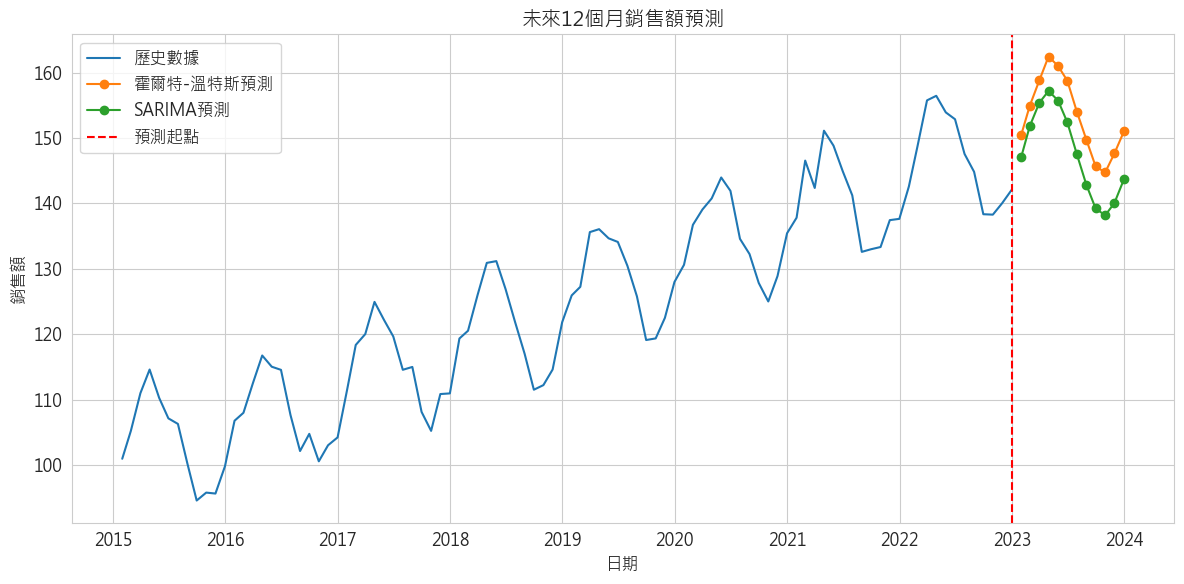

In [71]:
# 4.5 預測未來時間段
# 使用表現最佳的模型預測未來12個月
future_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# 使用霍爾特-溫特斯加法模型和SARIMA模型進行預測
hw_model_full = ExponentialSmoothing(
    monthly_sales, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()
hw_forecast = hw_model_full.forecast(12)

sarima_model_full = SARIMAX(
    monthly_sales, 
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 12)
).fit(disp=False)
sarima_forecast = sarima_model_full.forecast(12)

# 可視化未來預測
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='歷史數據')
plt.plot(future_dates, hw_forecast.values, 'o-', label='霍爾特-溫特斯預測')
plt.plot(future_dates, sarima_forecast.values, 'o-', label='SARIMA預測')
plt.title('未來12個月銷售額預測')
plt.xlabel('日期')
plt.ylabel('銷售額')
plt.axvline(x=monthly_sales.index[-1], color='r', linestyle='--', label='預測起點')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

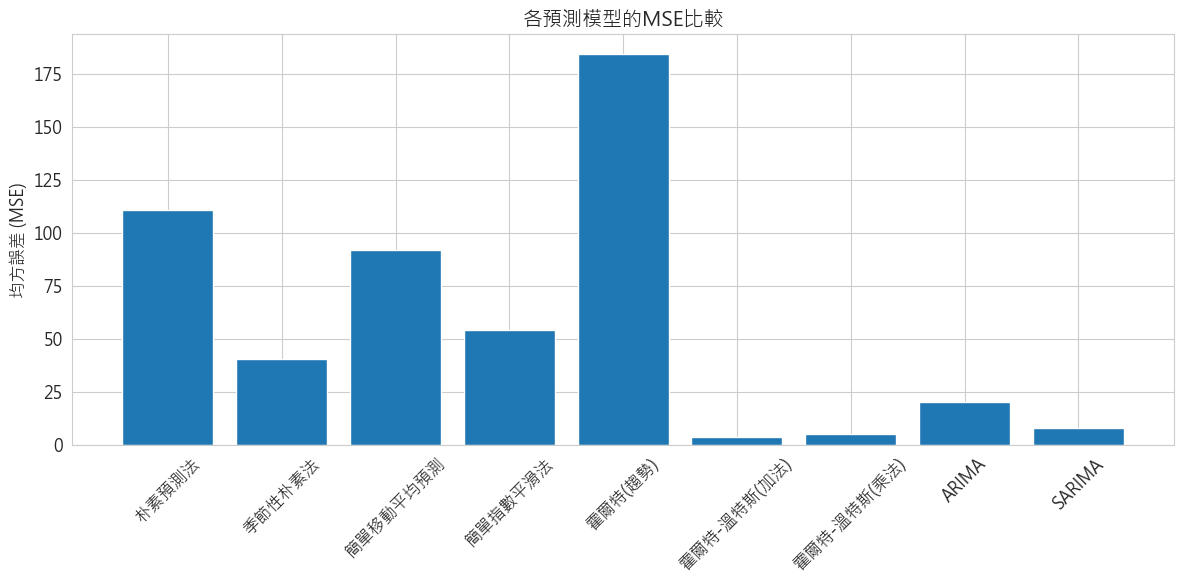

最佳預測方法是 霍爾特-溫特斯(加法)，MSE為 3.68


In [72]:
# 4.6 比較所有模型的預測性能
methods = {
    '朴素預測法': naive_mse,
    '季節性朴素法': seasonal_mse,
    '簡單移動平均預測': sma_mse,
    '簡單指數平滑法': ses_mse,
    '霍爾特(趨勢)': holt_mse,
    '霍爾特-溫特斯(加法)': hw_add_mse,
    '霍爾特-溫特斯(乘法)': hw_mult_mse,
    'ARIMA': arima_mse,
    'SARIMA': sarima_mse
}

# 繪製模型誤差對比圖
plt.figure(figsize=(12, 6))
plt.bar(methods.keys(), methods.values())
plt.title('各預測模型的MSE比較')
plt.ylabel('均方誤差 (MSE)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

best_method = min(methods, key=methods.get)
print(f"最佳預測方法是 {best_method}，MSE為 {methods[best_method]:.2f}")

解說：
- 時間序列預測可以使用多種方法，從簡單的朴素預測到複雜的統計模型
- 簡單方法包括：朴素預測法、季節性朴素法和移動平均法
- 指數平滑法具有不同複雜度的變種：
  * 簡單指數平滑 (SES) - 適用於無趨勢無季節性的數據
  * 霍爾特 (Holt) - 處理有趨勢的數據
  * 霍爾特-溫特斯 (Holt-Winters) - 同時處理趨勢和季節性
- ARIMA模型是一種強大的統計預測方法，包括:
  * 自迴歸 (AR) - 使用過去值的線性組合進行預測
  * 整合 (I) - 通過差分使時間序列平穩
  * 移動平均 (MA) - 使用過去預測誤差的線性組合
- SARIMA模型為ARIMA模型的季節性擴展
- 選擇適當的預測模型需要考慮數據特性和模型複雜度


## 📋 5. 總結


在本課程中，我們學習了時間序列的進階分析技術：

- **重採樣與頻率轉換**：通過 `resample()` 方法進行上採樣和下採樣，理解不同頻率資料的轉換方法。
- **移動窗口計算**：使用 `rolling()` 和 `ewm()` 等方法，計算滾動統計量和趨勢指標，洞察時間序列的動態變化。
- **季節性分解**：拆分時間序列為趨勢、季節性和殘差成分，深入理解數據的內在模式和結構。
- **時間序列預測**：學習各種預測方法，從簡單的朴素預測到複雜的ARIMA和SARIMA模型，預測時間序列的未來值。

這些技術為分析時間序列資料提供了強大的工具集，可以應用於金融市場分析、銷售預測、網站流量分析等多種領域。掌握這些技術可以幫助您從時間相關的數據中提取有價值的見解，並做出更準確的預測。

在實際應用中，建議結合領域知識和統計分析，選擇合適的時間序列分析方法，並謹慎評估模型性能，以達到最佳的分析效果。